In [1]:
''' Train GaussianNB model on HIGGS classification problem and submit to competition.
Author: Peter Sadowski
Date: Feb 12 2024
'''
import numpy as np 
import matplotlib.pylab as plt 
import sklearn 
from sklearn.naive_bayes import GaussianNB 
import sklearn.metrics 
from sklearn.ensemble import *
from sklearn.model_selection import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data = np.loadtxt('input/train.csv', skiprows=1, delimiter=',')

# Any results you write to the current directory are saved as output.

input/test.csv
input/train.csv
input/sample_submission.csv


# Train and Assess Model

In [2]:
# Split off validation set for testing.
Xtrain = data[:40000, 1:]
Ytrain = data[:40000, 0:1]
Xvalid = data[40000:, 1:]
Yvalid = data[40000:, 0:1]

In [12]:
np.std(Xtrain)

0.9691902453667861

In [11]:
np.mean(Xtrain)

0.6072756473949086

# RFC Normal 

Validation AUROC: 0.7854580959970568


Text(0, 0.5, 'True Positive Rate')

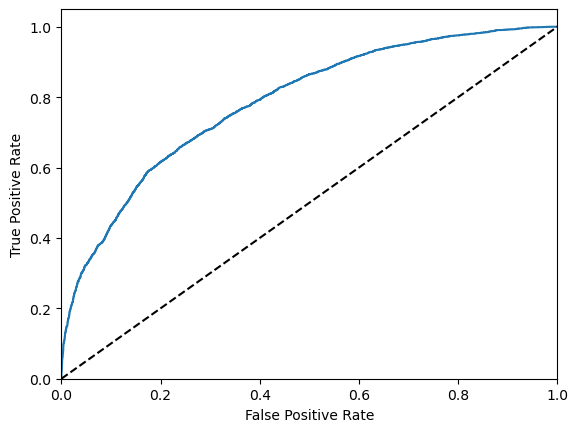

In [6]:
model = RandomForestClassifier(n_estimators=100, max_depth=15)
model.fit(Xtrain, Ytrain.flatten())

# Make hard predictions.
hard_predictions = model.predict(Xvalid)

# Make probabilistic predictions.
predictions = model.predict_proba(Xvalid)

# Compute AUROC.
val = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
print(f'Validation AUROC: {val}' )

# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# RFC with Random Search (worse than w/o searching)

In [2]:
# Fit model to train.
# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }

# from sklearn.model_selection import GridSearchCV

# model = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, 
#                     cv=20, n_jobs=-1)

# model = RandomForestClassifier(max_depth=15, n_estimators=100)

from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

param_dist = {'n_estimators': stats.randint(50,500),
              'max_depth': stats.randint(1,20)}
model = RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_dist, n_iter=5, cv=5)
model.fit(Xtrain, Ytrain.flatten())

# Create a variable for the best model
best_rf = model.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  model.best_params_)
# Best hyperparameters: {'max_depth': 10, 'n_estimators': 290}


# Make hard predictions.
hard_predictions = best_rf.predict(Xvalid)

# Make probabilistic predictions.
predictions = best_rf.predict_proba(Xvalid)

# Compute AUROC.
val = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
print(f'Validation AUROC: {val}' )

# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Validation AUROC: 0.7799594839962026


Text(0, 0.5, 'True Positive Rate')

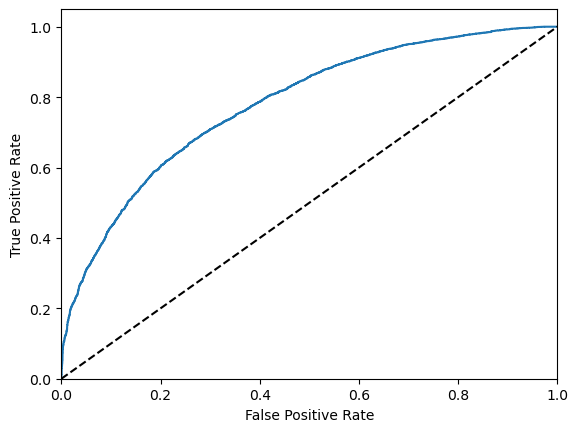

In [4]:
model = RandomForestClassifier(n_estimators=290, max_depth=10)
model.fit(Xtrain, Ytrain.flatten())

# Make hard predictions.
hard_predictions = model.predict(Xvalid)

# Make probabilistic predictions.
predictions = model.predict_proba(Xvalid)

# Compute AUROC.
val = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
print(f'Validation AUROC: {val}' )

# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Bayesian Optimization with skopt (very slow, cancelled and untested)

In [ ]:
from skopt import BayesSearchCV

# Define the search space for hyperparameters
param_space = {
    'n_estimators': (10, 1000),
    'max_depth': (1, 100)
}

# hack for skopt outdated
import numpy as np
np.int = int

# Initialize Bayesian optimization
# https://scikit-optimize.github.io/stable/modules/bayessearchcv.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
opt = BayesSearchCV(
    RandomForestClassifier(),
    param_space,
    n_iter=50,  # Number of iterations
    cv=5,
    scoring='roc_auc'
)

# Run optimization
opt.fit(Xtrain, Ytrain.flatten())

# Get best hyperparameters
best_params = opt.best_params_
print("Best Hyperparameters:", best_params)

# Train model with best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(Xtrain, Ytrain.flatten())

# Make probabilistic predictions
predictions = best_model.predict_proba(Xvalid)

# Compute AUROC
val = roc_auc_score(Yvalid[:, 0], predictions[:, 1])
print(f'Validation AUROC: {val}')

# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:, 0], predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# XGBoost

Validation AUROC: 0.7945081696098938


Text(0, 0.5, 'True Positive Rate')

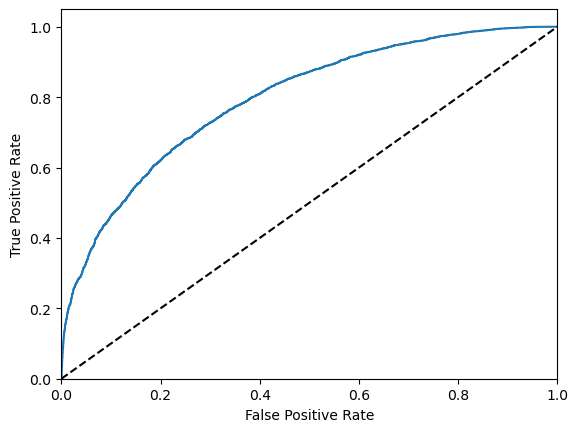

In [8]:
import xgboost as xgb
# https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

# model = xgb.XGBClassifier(n_estimators=100, max_depth=15, learning_rate=0.1, random_state=42, n_jobs=-1) # 0.790971782710599
# model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, min_child_weight=1, gamma=0) # 0.7919369864145887

# copied from somewhere
model = xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=-1,
 random_state=42,
 scale_pos_weight=1
) # 0.7945081696098938

model.fit(Xtrain, Ytrain.flatten())

# Make hard predictions.
hard_predictions = model.predict(Xvalid)

# Make probabilistic predictions.
predictions = model.predict_proba(Xvalid)

# Compute AUROC.
val = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
print(f'Validation AUROC: {val}' )

# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# XGBoost with Hyperopt

https://hyperopt.github.io/hyperopt/?source=post_page

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning#4.-Bayesian-Optimization-with-HYPEROPT-

https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

0.8003919706693526
- {'colsample_bytree': 0.6434178103266986, 'gamma': 0.1, 'learning_rate': 0.016951805688216377, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 500, 'reg_lambda': 0.8681598367089582}

0.8015886817609965
- {'colsample_bytree': 0.634773166725724, 'gamma': 1.5641000812832375, 'learning_rate': 0.010417885267605457, 'max_depth': 12, 'min_child_weight': 1.4294921423171645, 'n_estimators': 1000, 'reg_lambda': 0.8143493244635522}

100%|██████████| 100/100 [08:02<00:00,  4.83s/trial, best loss: -0.8003919706693526]
{'colsample_bytree': 0.6434178103266986, 'gamma': 0.1, 'learning_rate': 0.016951805688216377, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 500, 'reg_lambda': 0.8681598367089582}
Validation AUROC: 0.8003919706693526


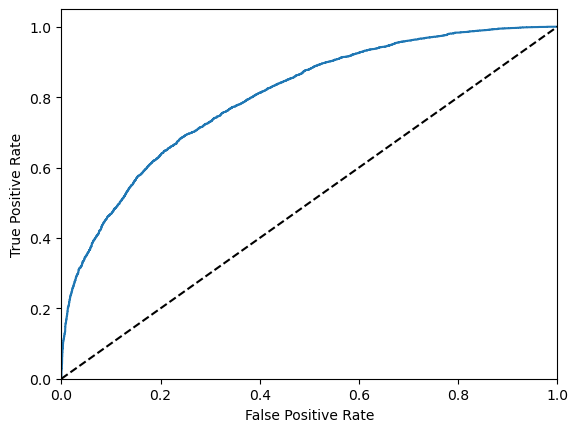

In [52]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

# Define the objective function
def objective(params):
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    model.fit(Xtrain, Ytrain.flatten())
    predictions = model.predict_proba(Xvalid)
    auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
    return -auc  # Hyperopt minimizes the objective function, so we negate AUROC

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 500]),
    'max_depth': hp.choice('max_depth', [5, 10, 15, 20]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'min_child_weight': hp.choice('min_child_weight', [1, 3, 5]),
    'gamma': hp.choice('gamma', [0, 0.1, 0.2]),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Train the final model
best_model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)
print(best_params)
best_model.fit(Xtrain, Ytrain.flatten())

# Evaluate the final model
val_predictions = best_model.predict_proba(Xvalid)
val_auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], val_predictions[:,1])
print(f'Validation AUROC: {val_auc}')

# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], val_predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

100%|██████████| 100/100 [09:32<00:00,  5.73s/trial, best loss: -0.8015886817609965]
{'colsample_bytree': 0.634773166725724, 'gamma': 1.5641000812832375, 'learning_rate': 0.010417885267605457, 'max_depth': 12, 'min_child_weight': 1.4294921423171645, 'n_estimators': 1000, 'reg_lambda': 0.8143493244635522}
Validation AUROC: 0.8015886817609965


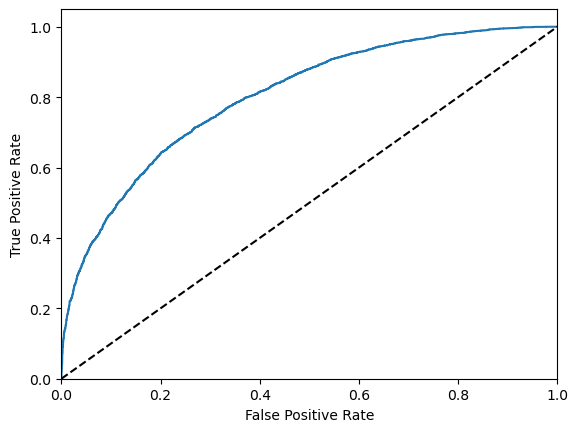

In [4]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

# Define the objective function
def objective(params):
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    model.fit(Xtrain, Ytrain.flatten())
    predictions = model.predict_proba(Xvalid)
    auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
    return -auc  # Hyperopt minimizes the objective function, so we negate AUROC

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', [300, 500, 1000]),
    'max_depth': hp.choice('max_depth', [10, 12, 15]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 5),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    # 'booster': hp.choice('booster', ['gbtree', 'dart']), # testing dart is REALLY slow -- don't do it.
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Train the final model
best_model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)
print(best_params)
best_model.fit(Xtrain, Ytrain.flatten())

# Evaluate the final model
val_predictions = best_model.predict_proba(Xvalid)
val_auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], val_predictions[:,1])
print(f'Validation AUROC: {val_auc}')

# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], val_predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

100%|██████████| 100/100 [06:42<00:00,  4.03s/trial, best loss: -0.8008381620653017]
{'colsample_bytree': 0.9221783072585483, 'gamma': 0.09634874265595483, 'learning_rate': 0.022074927499262976, 'max_depth': 10, 'min_child_weight': 2.531765867226485, 'n_estimators': 500, 'reg_lambda': 0.6977143327014788}
Validation AUROC: 0.8008381620653017


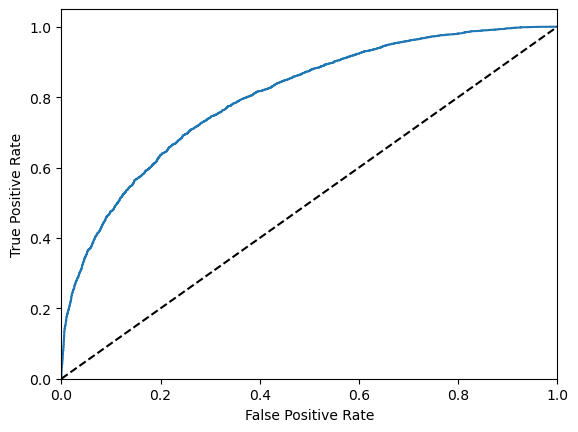

In [8]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

# Define the objective function
def objective(params):
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    model.fit(Xtrain, Ytrain.flatten())
    predictions = model.predict_proba(Xvalid)
    auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
    return -auc  # Hyperopt minimizes the objective function, so we negate AUROC

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', [500, 1000]), # doesn't seem to pick 300 ever.
    'max_depth': hp.choice('max_depth', [5, 10, 15]), # doesn't seem to ever pick 12 or 15. 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 3), # not usually above 3
    'gamma': hp.uniform('gamma', 0, 3), # doesn't usually choose gamma values above 3
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Train the final model
best_model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)
print(best_params)
best_model.fit(Xtrain, Ytrain.flatten())

# Evaluate the final model
val_predictions = best_model.predict_proba(Xvalid)
val_auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], val_predictions[:,1])
print(f'Validation AUROC: {val_auc}')

# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], val_predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

100%|██████████| 100/100 [08:37<00:00,  5.18s/trial, best loss: -0.8007838529003908]
{'colsample_bytree': 0.6608060476485426, 'gamma': 0.873741777347712, 'learning_rate': 0.01037640833550447, 'max_depth': 10, 'min_child_weight': 1.7803504615713335, 'n_estimators': 1000, 'objective': 'reg:logistic', 'reg_lambda': 0.9196698491170752}
Validation AUROC: 0.8007838529003908


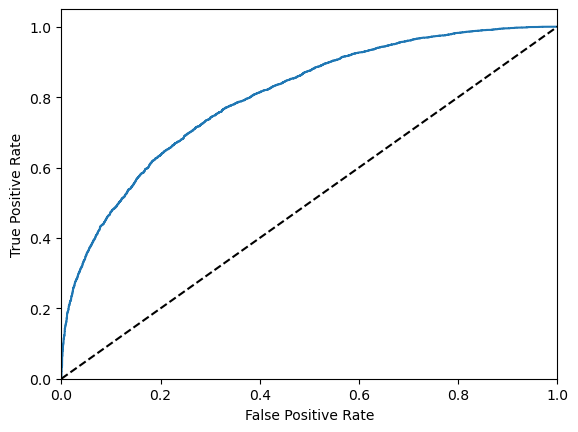

In [10]:
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np

# Define the objective function
def objective(params):
    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    model.fit(Xtrain, Ytrain.flatten())
    predictions = model.predict_proba(Xvalid)
    auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
    return -auc  # Hyperopt minimizes the objective function, so we negate AUROC

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', [300, 500, 1000]),
    'max_depth': hp.choice('max_depth', [10, 12, 15]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'min_child_weight': hp.uniform('min_child_weight', 1, 5),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
    'objective': hp.choice('objective', ['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic']),
}

# Perform optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Get the best hyperparameters
best_params = space_eval(space, best)

# Train the final model
best_model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)
print(best_params)
best_model.fit(Xtrain, Ytrain.flatten())

# Evaluate the final model
val_predictions = best_model.predict_proba(Xvalid)
val_auc = sklearn.metrics.roc_auc_score(Yvalid[:,0], val_predictions[:,1])
print(f'Validation AUROC: {val_auc}')

# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], val_predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# AdaBoostClassifier

https://github.com/log0/higgs_boson/

/home/echung32/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation AUROC: 0.803064797627409


Text(0, 0.5, 'True Positive Rate')

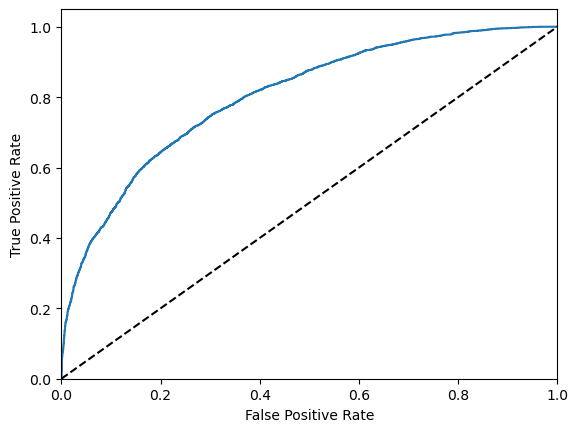

In [36]:
model = AdaBoostClassifier(
    ExtraTreesClassifier(
        n_estimators = 400,
        max_features = 30,
        max_depth = 12,
        min_samples_leaf = 100,
        min_samples_split = 100,
        n_jobs = -1
    ),
    n_estimators = 20,
    algorithm = "SAMME.R",
    learning_rate = 0.75,
    random_state = 42
)

model.fit(Xtrain, Ytrain.flatten())

# Make hard predictions.
hard_predictions = model.predict(Xvalid)

# Make probabilistic predictions.
predictions = model.predict_proba(Xvalid)

# Compute AUROC.
val = sklearn.metrics.roc_auc_score(Yvalid[:,0], predictions[:,1])
print(f'Validation AUROC: {val}' )

# Plot ROC curve.
fpr, tpr, thresholds = sklearn.metrics.roc_curve(Yvalid[:,0], predictions[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Make Predictions on Test Set

In [6]:
# Make probabilistic predictions.
Xtest1 = np.loadtxt('input/test.csv', skiprows=1, delimiter=',')
# predictions = model.predict_proba(Xtest1)
predictions = best_model.predict_proba(Xtest1)

predictions = predictions[:,1:2] # Probability that label=1
N = predictions.shape[0]
assert N == 50000, "Predictions should have lenght 50000."
submission = np.hstack((np.arange(N).reshape(-1,1), predictions)) # Add Id column.
np.savetxt(fname='submission8015886817609965.csv', X=submission, header='Id,Predicted', delimiter=',', comments='')

# Submission can be downloaded from this Kaggle Notebook under Sessions->Data->output->/kaggle/working.